# Sports Activities Recognization using Tensorflow 2.1-GPU,ResNet & OpenCV

Imports Libraries

In [1]:
import os
import cv2
import numpy as np
import argparse
import pickle
import matplotlib.pyplot as plt
import imutils
from imutils import paths

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

Parse Command Line Arguments

In [2]:
#construct the arguments and parse the arguments
ap=argparse.ArgumentParser()

ap.add_argument("--dataset",required=True,help=" path to input dataset")
ap.add_argument("--model",required=True,help="path of outpur serialized model")
ap.add_argument("--label_bin",required=True,help="opath to output label binalizer")

args=vars(ap.parse_args(["--dataset",r"C:\Users\SRKT\Desktop\sports_activity_dataset",
                        "--model",r"C:\Users\SRKT\Desktop\sports_activity_dataset",
                        "--label_bin",r"C:\Users\SRKT\Desktop\sports_activity_dataset"]))

Data Loading & Labeling

In [3]:
#initialize the sets of labels from the sports activity dataset we are going to train our network on
LABELS=["diving-Side","golf","kicking","lifting","riding-Hourse","walk-Front"]

#grab the list of image in our dataset directory , then initialize the list of data(i.e image) and class image
image_paths=list(paths.list_images(args["dataset"]))

data=[]
labels=[]

#loop over the image paths
for image_path in image_paths:
    
    #extract the class label from the file_name
    label=image_path.split(os.path.sep)[-2]
    
    #load the image , convert it to RGB channel ordering and resize it
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(224,224))
    
    #update the data and labels lists
    labels.append(label)
    data.append(image)
    

In [4]:
#convert the data and labels to numpy array
data=np.array(data)
labels=np.array(labels)

#perform one hot encoding on the labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels)

In [5]:
#training-testing split 
(x_train,x_test,y_train,y_test)=train_test_split(data,labels,test_size=0.25,stratify=labels,random_state=42)

Data Augmentation

In [6]:
#initialize the training data augmentaion object
train_aug=ImageDataGenerator(rotation_range=30,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

#initialzie the validation/testing data augmentation object(which we will be adding meand subtracting too)
val_aug=ImageDataGenerator()

#define the ImageNet mean subtracting (in RGB order) and set the mean subtracting value for each of the data augmentation object
mean=np.array([123.68,116.779,103.939],dtype="float32")
train_aug.mean=mean
val_aug.mean=mean

Model Bulding

In [7]:
#load the ResNet50 network,ensuring the head FC sets are left off
baseModel=ResNet50(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

#construct the head model which will be placed on top of base model
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(512,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(len(lb.classes_),activation="softmax")(headModel)

#place the head FC on top of base model (this will actually model to train )
model=Model(inputs=baseModel.input,outputs=headModel)

#loop over all the layers in the base model and freeze so they will not update during training
for layer in baseModel.layers:
    layer.trainable=False
    
#We’ll now freeze the baseModel so that it will not be trained via backpropagation 

Model Training

In [8]:
#compile the model
batch_size=32
epochs=25
opt=SGD(lr=1e-4,momentum=0.9,decay=1e-4/50)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

#train the head of the network for a few epochs (all other are frozen)-- this will allow  the new FC layers to
#start to become intialize with actual "learned" values pure random

#update in tensorflow 2 where we can use fit in place of fit_generator while data augmentations

H=model.fit_generator(
            train_aug.flow(x_train,y_train,batch_size=batch_size),
            steps_per_epoch=len(x_train)//batch_size,
            validation_data=val_aug.flow(x_test,y_test),
            validation_steps=len(x_test)//batch_size,
            epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 68 steps, validate for 22 steps
Epoch 1/25
68/68 [==============================] - 122s 2s/step - loss: 1.8162 - accuracy: 0.3119 - val_loss: 1.3395 - val_accuracy: 0.5028
Epoch 2/25
68/68 [==============================] - 36s 528ms/step - loss: 1.1225 - accuracy: 0.6020 - val_loss: 0.9553 - val_accuracy: 0.6776
Epoch 3/25
68/68 [==============================] - 38s 565ms/step - loss: 0.8158 - accuracy: 0.7426 - val_loss: 0.7458 - val_accuracy: 0.7784
Epoch 4/25
68/68 [==============================] - 43s 629ms/step - loss: 0.6451 - accuracy: 0.8172 - val_loss: 0.6382 - val_accuracy: 0.8011
Epoch 5/25
68/68 [==============================] - 42s 615ms/step - loss: 0.5192 - accuracy: 0.8704 - val_loss: 0.5601 - val_accuracy: 0.8153
Epoch 6/25
68/68 [==============================] - 43s 633ms/step - loss: 0.4628 - accuracy: 0.8811 - val_loss: 0.5074

Model Evaluate

In [9]:
#evaluate the network
predictions=model.predict(x=x_test.astype("float32"),batch_size=32)
print("Classification report",classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1),target_names=lb.classes_))

Classification report               precision    recall  f1-score   support

 diving-Side       0.99      0.99      0.99       137
        golf       1.00      0.47      0.64       105
     kicking       0.48      1.00      0.65        75
     lifting       0.99      1.00      0.99       176
riding-Horse       1.00      0.85      0.92       120
  walk-Front       1.00      0.92      0.96       118

    accuracy                           0.88       731
   macro avg       0.91      0.87      0.86       731
weighted avg       0.94      0.88      0.89       731



Plot The Graph

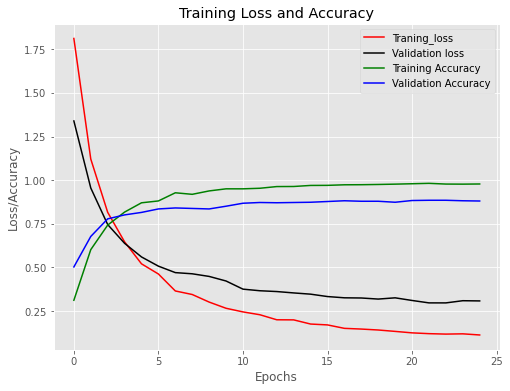

In [10]:
#plot the train loss and accuracy 
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,epochs),H.history["loss"],label="Traning_loss",color="red")
plt.plot(np.arange(0,epochs),H.history["val_loss"],label="Validation loss",color="black")
plt.plot(np.arange(0,epochs),H.history["accuracy"],label="Training Accuracy",color="green")
plt.plot(np.arange(0,epochs),H.history["val_accuracy"],label="Validation Accuracy",color="blue")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()


Model Save

In [16]:
#serialize the model to disk
model.save(r"C:\Users\SRKT\Desktop\sports_activity_dataset\model\model.h5",save_format="h5")

#serialize the label binarizer to disk
f=open(r"C:\Users\SRKT\Desktop\sports_activity_dataset\label\lb_bin","wb")
f.write(pickle.dumps(lb))
f.close()
